# Semantic Function Analysis of 'run'
This notebook extracts BERT-based semantic trajectories for the word **'run'** in 50 contexts, computes 12-layer embeddings, projects them into 3D, and visualizes the result color-coded by **manually labeled semantic function** (e.g., descriptive, narrative, performative, etc.).

In [7]:
# !pip install transformers torch scikit-learn matplotlib


In [8]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from transformers import BertTokenizer, BertModel
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import get_cmap


In [9]:
sentences = [
    # Descriptive
    "The river runs along the edge of the valley.",
    "The software runs silently in the background.",
    "The contract runs until the end of the fiscal year.",
    "The train runs every 30 minutes on weekdays.",
    "The faucet was left on, and water began to run over.",
    "The app runs on both Android and iOS devices.",
    "The treadmill runs at a maximum speed of 12 mph.",
    "The ink began to run when the paper got wet.",
    "The path runs parallel to the coastline.",
    "The machine runs continuously for eight hours.",
    "This show has run for over 200 episodes.",
    "The code runs without errors on the server.",

    # Narrative
    "He ran through the forest, dodging low branches.",
    "She ran to catch the bus just in time.",
    "I ran into him at the conference last year.",
    "They ran out of the theater when the fire alarm rang.",
    "He ran across the field with the ball in his hands.",
    "She ran back inside to grab her keys.",
    "After the meeting, he ran straight to the elevator.",
    "The child ran ahead to see the parade.",
    "They ran for cover when the rain started.",
    "The dog ran circles around the children.",
    "I ran errands all morning and didn’t rest once.",
    "She ran down the stairs, laughing all the way.",

    # Evaluative
    "He let his imagination run wild during the pitch.",
    "That joke is starting to run thin.",
    "She always runs hot and cold in her opinions.",
    "The rumor ran rampant on social media.",
    "His speech ran a bit too long.",
    "The story ran its course by the second season.",
    "The campaign is running out of steam.",
    "Her style runs counter to current trends.",
    "His enthusiasm ran high before the exam.",
    "This explanation is running on empty.",
    "The concept runs deeper than it first appears.",
    "He’s letting emotions run the conversation.",

    # Performative
    "Run the test again with different parameters.",
    "Run the simulation after adjusting the variables.",
    "Run your idea by the team first.",
    "Let’s run through the checklist one last time.",
    "Please run this by legal before signing.",
    "Run diagnostics before restarting the device.",
    "Don't run that script in production.",
    "Let’s run a quick rehearsal before launch.",
    "Can you run the report before 5 PM?",
    "Run the numbers and get back to me.",
    "Run the update overnight to avoid delays.",
    "Go ahead and run it — we’re ready."
]


In [10]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased", output_hidden_states=True)
model.eval()

trajectories = []
valid_sentences = []

for sent in sentences:
    inputs = tokenizer(sent, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    input_ids = inputs["input_ids"][0]
    tokens = tokenizer.convert_ids_to_tokens(input_ids)
    indices = [i for i, tok in enumerate(tokens) if "run" in tok]
    if not indices:
        continue
    index = indices[0]
    layers = outputs.hidden_states[-12:]
    curve = torch.stack([layer[0, index] for layer in layers])
    trajectories.append(curve.numpy())
    valid_sentences.append(sent)

print(f"✅ Extracted {len(trajectories)} valid 'run' trajectories.")


✅ Extracted 32 valid 'run' trajectories.


In [11]:
filtered_trajectories = [t for t in trajectories if t.shape[0] == 12]
flat = np.concatenate(filtered_trajectories, axis=0)
pca = PCA(n_components=3)
reduced = pca.fit_transform(flat)
curves_3d = reduced.reshape(len(filtered_trajectories), 12, 3)


In [12]:
function_labels = [
    "descriptive", "descriptive", "performative", "descriptive", "descriptive",
    "descriptive", "descriptive", "descriptive", "evaluative", "descriptive",
    "narrative", "narrative", "descriptive", "descriptive", "descriptive",
    "evaluative", "performative", "descriptive", "narrative", "descriptive",
    "descriptive", "descriptive", "descriptive", "evaluative", "descriptive",
    "descriptive", "descriptive", "evaluative", "narrative", "narrative",
    "narrative", "narrative", "descriptive", "descriptive", "descriptive",
    "performative", "evaluative", "descriptive", "evaluative", "descriptive",
    "performative", "narrative", "narrative", "descriptive", "descriptive",
    "descriptive", "evaluative", "performative", "performative", "performative"
]


/var/folders/wg/v_zmfv8n04z8f3cf0cz2d9jr0000gn/T/ipykernel_49231/3223236448.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = get_cmap("tab10").colors


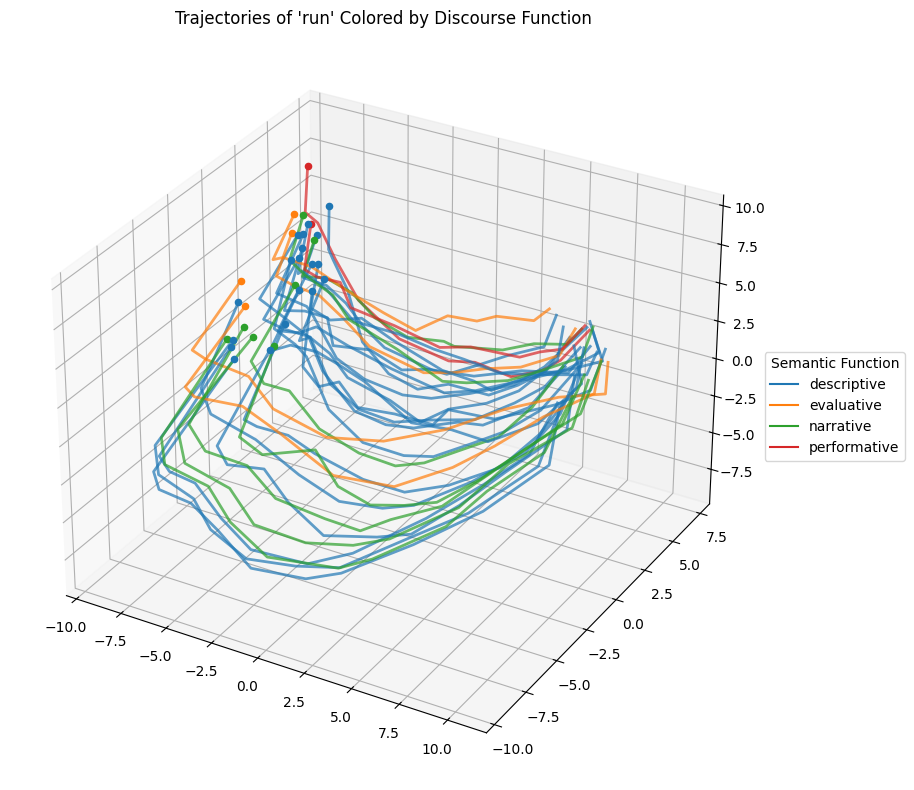

In [13]:
categories = sorted(set(function_labels))
colors = get_cmap("tab10").colors
label_color_map = {label: colors[i % len(colors)] for i, label in enumerate(categories)}

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for i, curve in enumerate(curves_3d):
    label = function_labels[i]
    color = label_color_map[label]
    xs, ys, zs = curve[:, 0], curve[:, 1], curve[:, 2]
    ax.plot(xs, ys, zs, color=color, linewidth=2, alpha=0.7)
    ax.scatter(xs[-1], ys[-1], zs[-1], c=[color], s=20)

for label, color in label_color_map.items():
    ax.plot([], [], [], color=color, label=label)
ax.legend(title="Semantic Function", loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title("Trajectories of 'run' Colored by Discourse Function")
plt.tight_layout()
plt.show()
